In [1]:
!pip install torchtext
!pip install torch==2.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 46.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 23.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

In [3]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.1 MB/s eta 0:00:00


In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
import sacrebleu
import io

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        for line in f:
            yield line.strip().split()

In [6]:
max_length = 82

def make_dataloaders(vocab_de, vocab_en, batch_size=128):
    de_tokens_train = []
    for line in yield_tokens("/kaggle/input/translation/data/train.de-en.de"):
        middle = [vocab_de[word] if word in vocab_de else vocab_de["<unk>"] for word in line]
        length = len(middle) + 2
        if length > max_length:
            indices = [vocab_de["<bos>"]] + middle[:max_length - 2] + [vocab_de["<eos>"]]
        else:
            indices = [vocab_de["<bos>"]] + middle + [vocab_de["<eos>"]] + [vocab_de["<pad>"]] * (max_length - length)
        de_tokens_train.append(indices)

    en_tokens_train = []
    for line in yield_tokens("/kaggle/input/translation/data/train.de-en.en"):
        middle = [vocab_en[word] if word in vocab_en else vocab_en["<unk>"] for word in line]
        length = len(middle) + 2
        if length > max_length:
            indices = [vocab_en["<bos>"]] + middle[:max_length - 2] + [vocab_en["<eos>"]]
        else:
            indices = [vocab_en["<bos>"]] + middle + [vocab_en["<eos>"]] + [vocab_en["<pad>"]] * (max_length - length)
        en_tokens_train.append(indices)

    de_tokens_val = []
    for line in yield_tokens("/kaggle/input/translation/data/val.de-en.de"):
        middle = [vocab_de[word] if word in vocab_de else vocab_de["<unk>"] for word in line]
        length = len(middle) + 2
        if length > max_length:
            indices = [vocab_de["<bos>"]] + middle[:max_length - 2] + [vocab_de["<eos>"]]
        else:
            indices = [vocab_de["<bos>"]] + middle + [vocab_de["<eos>"]] + [vocab_de["<pad>"]] * (max_length - length)
        de_tokens_val.append(indices)

    en_tokens_val = []
    for line in yield_tokens("/kaggle/input/translation/data/val.de-en.en"):
        middle = [vocab_en[word] if word in vocab_en else vocab_en["<unk>"] for word in line]
        length = len(middle) + 2
        if length > max_length:
            indices = [vocab_en["<bos>"]] + middle[:max_length - 2] + [vocab_en["<eos>"]]
        else:
            indices = [vocab_en["<bos>"]] + middle + [vocab_en["<eos>"]] + [vocab_en["<pad>"]] * (max_length - length)
        en_tokens_val.append(indices)

    train_dataset = TensorDataset(torch.LongTensor(de_tokens_train).to(device), torch.LongTensor(en_tokens_train).to(device))
    val_dataset = TensorDataset(torch.LongTensor(de_tokens_val).to(device), torch.LongTensor(en_tokens_val).to(device))

    return DataLoader(train_dataset, batch_size, shuffle=True), DataLoader(val_dataset, batch_size, shuffle=False)
        

Архитектуру для Encoder/decoder/attention взял отсюда - https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [41]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(vocab_en["<bos>"])
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(max_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [42]:
def plot_losses(train_losses, val_losses):
    clear_output()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='val')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel("epoch")

    plt.show()

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in tqdm(dataloader):
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


@torch.no_grad()
def validation_epoch(dataloader, encoder, decoder, criterion):
    total_loss = 0
    for data in tqdm(dataloader):
        input_tensor, target_tensor = data

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [47]:
def evaluate(encoder, decoder, sentence, vocab_de, vocab_en):
    with torch.no_grad():
        indexes = [vocab_de["<bos>"]] + [vocab_de[word] if word in vocab_de else vocab_de["<unk>"] for word in sentence.split()] + [vocab_de["<eos>"]]
        input_tensor = torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == vocab_en["<bos>"]:
                continue
            if idx.item() == vocab_en["<eos>"]:
                break
            decoded_words.append(vocab_en.lookup_token(idx.item()))
    return decoded_words, decoder_attn

with open("/kaggle/input/translation/data/val.de-en.de") as f:
    with open("/kaggle/input/translation/data/val.de-en.en") as q:
        pairs = list(zip(f.readlines(), q.readlines()))

def evaluate_randomly(encoder, decoder, vocab_de, vocab_en, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], vocab_de, vocab_en)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [44]:
def train(train_dataloader, val_dataloader, encoder, decoder, n_epochs, vocab_de, vocab_en, learning_rate=0.001):
    train_losses = []
    val_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab_en["<pad>"])

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}")
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        val_loss = validation_epoch(val_dataloader, encoder, decoder, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        plot_losses(train_losses, val_losses)
        evaluate_randomly(encoder, decoder, vocab_de, vocab_en)

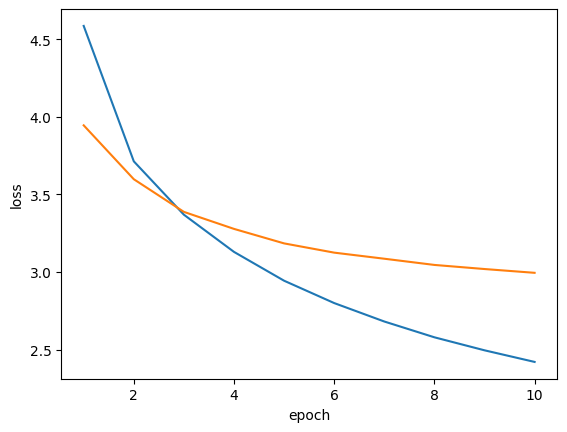

> und ich fragte mich , wie sie sich fühlen würden , wenn sie keinen zugang zu gesundem essen hätten , wenn sie jedes mal , wenn sie aus dem haus gehen , die negativen auswirkungen sehen , die das bestehende ernährungssystem auf ihr viertel hat .

= and i was wondering , how would you feel if you had no access to healthy food , if every time you walk out your door you see the ill effects that the present food system has on your neighborhood ?

< <bos> and i told you how to feel when you would have any food food , if you go back to your house , you know , the negative effects of the world , that 's the food system on your neighborhood , you 've got to the neighborhood , you can split your neighborhood on your neighborhood .

> ich meine , einige leute wollten ihn gouverneur washington nennen , und andere , seine hoheit george washington , und wieder andere , beschützer der freiheit der menschen der vereinigten staaten von amerika washington

= i mean , some people wanted him to be calle

In [46]:
hidden_size = 128

vocab_de = build_vocab_from_iterator(yield_tokens("/kaggle/input/translation/data/train.de-en.de"), specials=['<pad>', '<unk>', '<bos>', '<eos>'])
vocab_en = build_vocab_from_iterator(yield_tokens("/kaggle/input/translation/data/train.de-en.en"), specials=['<pad>', '<unk>', '<bos>', '<eos>'])
print(len(vocab_de), len(vocab_en))
train_loader, val_loader = make_dataloaders(vocab_de, vocab_en, 64)

encoder = EncoderRNN(len(vocab_de), hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, len(vocab_en)).to(device)

train(train_loader, val_loader, encoder, decoder, 10, vocab_de, vocab_en)

# Забыл легенду выводить, когда обучал, но вроде понятно, что оранжевая - валидация

In [53]:
with open("test_preds_2.de-en.en", "w") as f:
    with open("/kaggle/input/translation/data/test1.de-en.de") as test_read:
        for line in test_read.readlines():
            output_words, _ = evaluate(encoder, decoder, line, vocab_de, vocab_en)
            f.write(' '.join(output_words) + '\n')

In [54]:
torch.save(encoder.state_dict(), f'encoder_checkpoint.pt')
torch.save(decoder.state_dict(), f'decoder_checkpoint.pt')